In [1]:
# importy

import warnings
warnings.filterwarnings("ignore")

import os
os.environ['DYLD_LIBRARY_PATH'] = '/opt/homebrew/opt/libomp/lib/'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import yfinance as yf
import vectorbt as vbt

from sklearn.metrics import (
    accuracy_score, roc_auc_score, classification_report,
    confusion_matrix, ConfusionMatrixDisplay,
)

from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV

from sklearn.ensemble import RandomForestClassifier

from xgboost import XGBClassifier


In [2]:
# Ustawienia

TICKER = "AAPL"

TRAIN_START = "2015-01-01"
TRAIN_END   = "2023-12-31"

TEST_START  = "2024-01-01"
TEST_END    = "2024-05-06"

INIT_CASH = 10_000
FEE = 0.0005
SLIPPAGE = 0.0002

# UPPER = 0.52 - zamiast tego używane są progi z kwantyli
# LOWER = 0.48

In [3]:
# Feature engineering

def rsi(series: pd.Series, period: int = 14) -> pd.Series:
    delta = series.diff()
    gain = delta.clip(lower=0)
    loss = (-delta).clip(lower=0)
    avg_gain = gain.rolling(period).mean()
    avg_loss = loss.rolling(period).mean()
    rs = avg_gain / (avg_loss + 1e-12)
    return 100 - (100 / (1 + rs))

def atr(high: pd.Series, low: pd.Series, close: pd.Series, period: int = 14) -> pd.Series:
    prev_close = close.shift(1)
    tr = pd.concat([
        (high - low).abs(),
        (high - prev_close).abs(),
        (low - prev_close).abs()
    ], axis=1).max(axis=1)
    return tr.rolling(period).mean()

def add_features(d: pd.DataFrame) -> pd.DataFrame:
    df = d.copy()
    price = df["Adj Close"]

    # log returns
    df["ret_1"]  = np.log(price).diff(1)
    df["ret_3"]  = np.log(price).diff(3)
    df["ret_5"]  = np.log(price).diff(5)
    df["ret_10"] = np.log(price).diff(10)

    # SMAs
    for w in [10, 20, 50]:
        sma = price.rolling(w).mean()
        df[f"price_sma_{w}_ratio"] = price / (sma + 1e-12)

    # EMA
    ema20 = price.ewm(span=20, adjust=False).mean()
    df["price_ema_20_ratio"] = price / (ema20 + 1e-12)

    # RSI
    df["rsi_14"] = rsi(price, 14)

    # Bollinger (20)
    ma20 = price.rolling(20).mean()
    sd20 = price.rolling(20).std()
    upper = ma20 + 2 * sd20
    lower = ma20 - 2 * sd20
    df["bb_percent_b"] = (price - lower) / ((upper - lower) + 1e-12)
    df["bb_bandwidth"] = (upper - lower) / (ma20 + 1e-12)

    # Volatility
    df["vol_10"] = df["ret_1"].rolling(10).std()
    df["vol_20"] = df["ret_1"].rolling(20).std()

    # ATR
    df["atr_14"] = atr(df["High"], df["Low"], price, 14)

    # Candle features
    df["hl_pct"] = (df["High"] - df["Low"]) / (price + 1e-12)
    df["co_pct"] = (df["Close"] - df["Open"]) / (df["Open"] + 1e-12)

    # Volume features
    df["vol_chg"] = df["Volume"].pct_change(1)
    vol_mean20 = df["Volume"].rolling(20).mean()
    vol_std20  = df["Volume"].rolling(20).std()
    df["vol_z"] = (df["Volume"] - vol_mean20) / (vol_std20 + 1e-12)

    return df

In [4]:
raw = yf.download(TICKER, start=TRAIN_START, end=TEST_END, auto_adjust=False, progress=False)

import pandas as pd
if isinstance(raw.columns, pd.MultiIndex):
    raw.columns = raw.columns.get_level_values(0)

raw = raw[["Open", "High", "Low", "Close", "Adj Close", "Volume"]].dropna()

df = add_features(raw)

# kontrola
print(df.columns.tolist())

['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'ret_1', 'ret_3', 'ret_5', 'ret_10', 'price_sma_10_ratio', 'price_sma_20_ratio', 'price_sma_50_ratio', 'price_ema_20_ratio', 'rsi_14', 'bb_percent_b', 'bb_bandwidth', 'vol_10', 'vol_20', 'atr_14', 'hl_pct', 'co_pct', 'vol_chg', 'vol_z']


In [5]:
# Target: czy jutro wzrośnie (next-day)
df["fwd_ret_1"] = df["Adj Close"].pct_change(1).shift(-1)

COST = 2*(FEE + SLIPPAGE)  # wejście+wyjście
df["y"] = (df["fwd_ret_1"] > COST).astype(int)

feature_cols = [
    "ret_1","ret_3","ret_5","ret_10",
    "price_sma_10_ratio","price_sma_20_ratio","price_sma_50_ratio",
    "price_ema_20_ratio",
    "rsi_14","bb_percent_b","bb_bandwidth",
    "vol_10","vol_20","atr_14",
    "hl_pct","co_pct",
    "vol_chg","vol_z"
]

data = df.dropna(subset=feature_cols + ["y"]).copy()

train = data.loc[TRAIN_START:TRAIN_END].copy()
test  = data.loc[TEST_START:TEST_END].copy()

X_train, y_train = train[feature_cols], train["y"]
X_test,  y_test  = test[feature_cols],  test["y"]

pos = (y_train == 1).sum()
neg = (y_train == 0).sum()
spw = neg / max(pos, 1)
print("scale_pos_weight:", spw)

print("Train:", X_train.shape, "Test:", X_test.shape)

tscv = TimeSeriesSplit(n_splits=5)
auc_scorer = "roc_auc"

scale_pos_weight: 1.0720299345182414
Train: (2215, 18) Test: (86, 18)


In [6]:
# TUNING (RandomizedSearchCV, TimeSeriesSplit)

xgb_base = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    random_state=42,
    n_jobs=-1,
    tree_method="hist"
)

rf_base = RandomForestClassifier(
    random_state=42,
    n_jobs=-1
)

xgb_param_dist = {
    "n_estimators": [300, 500, 800, 1200, 1600],
    "max_depth": [2, 3, 4, 5, 6],
    "learning_rate": [0.005, 0.01, 0.03, 0.05],
    "subsample": [0.6, 0.75, 0.85, 1.0],
    "colsample_bytree": [0.6, 0.75, 0.85, 1.0],
    "min_child_weight": [1, 3, 5, 10, 20],
    "gamma": [0, 0.05, 0.1, 0.3, 1.0],
    "reg_lambda": [0.1, 0.5, 1.0, 2.0, 5.0, 10.0],
    "reg_alpha": [0.0, 0.01, 0.1, 0.5, 1.0],
    "scale_pos_weight": [1.0, spw, spw * 1.5],
}

rf_param_dist = {
    "n_estimators": [300, 600, 1000, 1500],
    "max_depth": [3, 5, 8, 12, 16, None],
    "min_samples_leaf": [1, 2, 3, 5, 10],
    "min_samples_split": [2, 5, 10, 20],
    "max_features": ["sqrt", "log2", 0.3, 0.5, 0.8],
    "class_weight": [None, "balanced"],
}

auc_scorer = "roc_auc"

xgb_search = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=xgb_param_dist,
    n_iter=100,
    scoring=auc_scorer,
    cv=tscv,
    random_state=42,
    n_jobs=-1,
    verbose=1,
    refit=True
)

rf_search = RandomizedSearchCV(
    estimator=rf_base,
    param_distributions=rf_param_dist,
    n_iter=80,
    scoring=auc_scorer,
    cv=tscv,
    random_state=42,
    n_jobs=-1,
    verbose=1,
    refit=True
)

xgb_search.fit(X_train, y_train)
rf_search.fit(X_train, y_train)

print("\n[XGB] Best AUC (CV):", xgb_search.best_score_)
print("[XGB] Best params:", xgb_search.best_params_)

print("\n[RF] Best AUC (CV):", rf_search.best_score_)
print("[RF] Best params:", rf_search.best_params_)

best_xgb = xgb_search.best_estimator_
best_rf  = rf_search.best_estimator_


Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 80 candidates, totalling 400 fits

[XGB] Best AUC (CV): 0.526092571130262
[XGB] Best params: {'subsample': 1.0, 'scale_pos_weight': 1.6080449017773621, 'reg_lambda': 1.0, 'reg_alpha': 1.0, 'n_estimators': 500, 'min_child_weight': 1, 'max_depth': 2, 'learning_rate': 0.01, 'gamma': 0, 'colsample_bytree': 1.0}

[RF] Best AUC (CV): 0.5220752340330821
[RF] Best params: {'n_estimators': 1000, 'min_samples_split': 10, 'min_samples_leaf': 10, 'max_features': 0.5, 'max_depth': None, 'class_weight': None}


XGBoost FIXED quantiles: upper_q=0.8, lower_q=0.3
XGBoost thresholds: upper=0.6341, lower=0.5801

=== XGBoost (TUNED) ===
Test ACC: 0.4186 | Test AUC: 0.5014
Test ACC (only decision days): 0.5294 | n=34
              precision    recall  f1-score   support

           0     0.6667    0.0392    0.0741        51
           1     0.4096    0.9714    0.5763        35

    accuracy                         0.4186        86
   macro avg     0.5382    0.5053    0.3252        86
weighted avg     0.5621    0.4186    0.2785        86



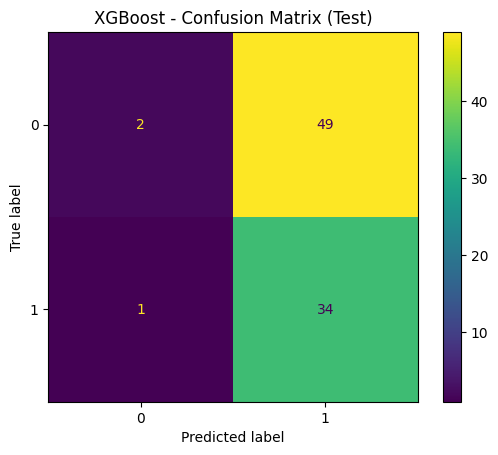

RandomForest FIXED quantiles: upper_q=0.7, lower_q=0.3
RandomForest thresholds: upper=0.5861, lower=0.3791

=== RandomForest (TUNED) ===
Test ACC: 0.4302 | Test AUC: 0.5092
Test ACC (only decision days): 0.4615 | n=13
              precision    recall  f1-score   support

           0     0.5238    0.4314    0.4731        51
           1     0.3409    0.4286    0.3797        35

    accuracy                         0.4302        86
   macro avg     0.4324    0.4300    0.4264        86
weighted avg     0.4494    0.4302    0.4351        86



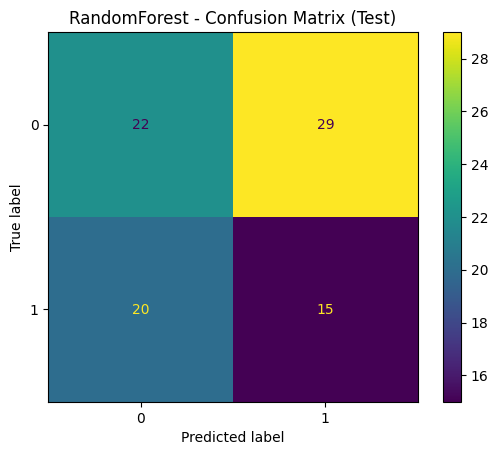

In [7]:
# Ewaluacja na TEST + zbieranie prawdopodobieństw do backtestu

models = {"XGBoost": best_xgb, "RandomForest": best_rf}

probs_test = {}

thresholds = {}

# STAŁE progi po teście stabilności - wybierane samodzielnie
FIXED_THRESHOLDS = {
    "XGBoost": (0.80, 0.30),
    "RandomForest": (0.70, 0.30),
}

for name, model in models.items():
    # model.fit(X_train, y_train)  # bezpiecznik
    if not hasattr(model, "classes_"):
        model.fit(X_train, y_train)

    upper_q, lower_q = FIXED_THRESHOLDS[name]
    p_train = pd.Series(model.predict_proba(X_train)[:, 1], index=X_train.index)

    upper = p_train.quantile(upper_q)
    lower = p_train.quantile(lower_q)
    thresholds[name] = (upper, lower)

    print(f"{name} FIXED quantiles: upper_q={upper_q}, lower_q={lower_q}")
    print(f"{name} thresholds: upper={upper:.4f}, lower={lower:.4f}")


    p_test = model.predict_proba(X_test)[:, 1]
    p_test = pd.Series(p_test, index=X_test.index, name="p_up")
    probs_test[name] = p_test

    # metryki klasyfikacji (próg 0.5)
    pred_test = (p_test >= 0.5).astype(int)

    acc = accuracy_score(y_test, pred_test)
    try:
        auc = roc_auc_score(y_test, p_test)
    except ValueError:
        auc = np.nan

    print(f"\n=== {name} (TUNED) ===")
    print(f"Test ACC: {acc:.4f} | Test AUC: {auc:.4f}")

    # EWALUACJA ZGODNA Z PROGAMI TRADINGOWYMI (tylko dni z decyzją)

    decision = pd.Series(index=p_test.index, dtype=float)
    decision[p_test > upper] = 1
    decision[p_test < lower] = 0

    mask = decision.notna()  # tylko dni gdzie jest sygnał
    if mask.sum() > 0:
        acc_decisions = accuracy_score(y_test[mask], decision[mask].astype(int))
        print(f"Test ACC (only decision days): {acc_decisions:.4f} | n={mask.sum()}")
    else:
        print("Test ACC (only decision days): brak dni decyzyjnych (mask=0)")

    print(classification_report(y_test, pred_test, digits=4))

    cm = confusion_matrix(y_test, pred_test)
    ConfusionMatrixDisplay(cm).plot()
    plt.title(f"{name} - Confusion Matrix (Test)")
    plt.show()



===== BACKTEST: XGBoost (upper=0.6341, lower=0.5801, cooldown=0) =====
Start                         2024-01-02 00:00:00
End                           2024-05-03 00:00:00
Period                           86 days 00:00:00
Start Value                               10000.0
End Value                            10954.494383
Total Return [%]                         9.544944
Benchmark Return [%]                    -1.091345
Max Gross Exposure [%]                      100.0
Total Fees Paid                         52.592868
Max Drawdown [%]                         5.523103
Max Drawdown Duration            63 days 00:00:00
Total Trades                                    5
Total Closed Trades                             5
Total Open Trades                               0
Open Trade PnL                                0.0
Win Rate [%]                                100.0
Best Trade [%]                           3.366299
Worst Trade [%]                           0.21828
Avg Winning Trade [%]       

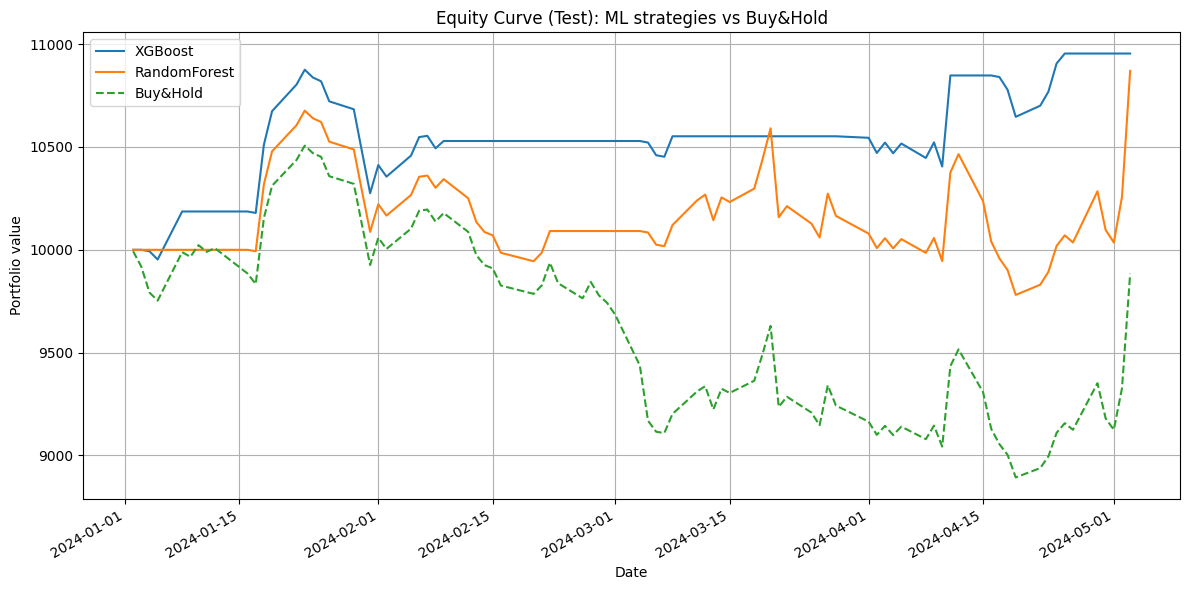


===== BACKTEST: Buy & Hold =====
Start                         2024-01-02 00:00:00
End                           2024-05-03 00:00:00
Period                           86 days 00:00:00
Start Value                               10000.0
End Value                             9883.945721
Total Return [%]                        -1.160543
Benchmark Return [%]                    -1.091345
Max Gross Exposure [%]                      100.0
Total Fees Paid                          4.997501
Max Drawdown [%]                        15.354777
Max Drawdown Duration            71 days 00:00:00
Total Trades                                    1
Total Closed Trades                             0
Total Open Trades                               1
Open Trade PnL                        -116.054279
Win Rate [%]                                  NaN
Best Trade [%]                                NaN
Worst Trade [%]                               NaN
Avg Winning Trade [%]                         NaN
Avg Losing Trade

In [8]:

def probs_to_position(p: pd.Series, upper: float = 0.55, lower: float = 0.45) -> pd.Series:
    """
    Zamienia prawdopodobieństwo klasy 1 (UP) na pozycję 0/1 z histerezą:
    - gdy p > upper -> wchodzimy LONG (1)
    - gdy p < lower -> wychodzimy do CASH (0)
    - w środku trzymamy poprzedni stan
    """
    pos = pd.Series(index=p.index, dtype=float)
    current = 0.0
    for i, v in enumerate(p.values):
        if v > upper:
            current = 1.0
        elif v < lower:
            current = 0.0
        pos.iloc[i] = current
    return pos

def run_backtest(name: str, p_up: pd.Series, test_df: pd.DataFrame, upper: float, lower: float, cooldown_days: int = 0):
    """
    p_up: pd.Series z prawdopodobieństwem klasy 1 (UP)
    """
    # 1) progi wejścia/wyjścia (histereza)
    pos = probs_to_position(p_up, upper=upper, lower=lower)

    # 2) cooldown: po zmianie pozycji trzymaj min. N dni
    last_change = -10**9
    current = 0.0
    for i, v in enumerate(pos.values):
        if i - last_change < cooldown_days:
            pos.iloc[i] = current
            continue
        if v != current:
            current = v
            last_change = i
        pos.iloc[i] = current

    entries = (pos.shift(1).fillna(0) == 0) & (pos == 1)
    exits   = (pos.shift(1).fillna(0) == 1) & (pos == 0)

    pf = vbt.Portfolio.from_signals(
        close=test_df["Adj Close"],
        entries=entries,
        exits=exits,
        init_cash=INIT_CASH,
        fees=FEE,
        slippage=SLIPPAGE,
        freq="D"
    )

    print(f"\n===== BACKTEST: {name} (upper={upper:.4f}, lower={lower:.4f}, cooldown={cooldown_days}) =====")
    print(pf.stats())
    return pf

# backtest modeli
portfolios = {
    name: run_backtest(
        name,
        p,
        test,
        upper=thresholds[name][0],
        lower=thresholds[name][1],
        cooldown_days=0
    )
    for name, p in probs_test.items()
}

# benchmark: buy&hold
bh = vbt.Portfolio.from_holding(
    close=test["Adj Close"],
    init_cash=INIT_CASH,
    fees=FEE,
    slippage=SLIPPAGE,
    freq="D"
)

# ===== JEDEN WSPÓLNY WYKRES: XGBoost vs RandomForest vs Buy&Hold =====

plt.figure(figsize=(12, 6))

for name, pf in portfolios.items():
    pf.value().plot(label=name)

bh.value().plot(label="Buy&Hold", linestyle="--")

plt.title("Equity Curve (Test): ML strategies vs Buy&Hold")
plt.xlabel("Date")
plt.ylabel("Portfolio value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print("\n===== BACKTEST: Buy & Hold =====")
print(bh.stats())

# porównanie kluczowych metryk
comp = pd.DataFrame({
    "XGBoost": portfolios["XGBoost"].stats(),
    "RandomForest": portfolios["RandomForest"].stats(),
    "BuyHold": bh.stats()
})

# TEST STABILNOŚCI PROGÓW

def threshold_stability_test(
    model_name: str,
    p_train: pd.Series,
    p_test: pd.Series,
    test_df: pd.DataFrame,
    upper_qs=(0.65, 0.7, 0.75, 0.8),
    lower_qs=(0.2, 0.25, 0.3),
):
    results = []

    for uq in upper_qs:
        for lq in lower_qs:
            if lq >= uq:
                continue

            upper = p_train.quantile(uq)
            lower = p_train.quantile(lq)

            pf = run_backtest(
                name=f"{model_name} uq={uq}, lq={lq}",
                p_up=p_test,
                test_df=test_df,
                upper=upper,
                lower=lower,
                cooldown_days=0
            )

            stats = pf.stats()

            results.append({
                "model": model_name,
                "upper_q": uq,
                "lower_q": lq,
                "Total Return [%]": stats["Total Return [%]"],
                "Sharpe Ratio": stats["Sharpe Ratio"],
                "Max Drawdown [%]": stats["Max Drawdown [%]"],
                "Total Trades": stats["Total Trades"],
            })

    return pd.DataFrame(results)


key_stats = [
    "Total Return [%]",
    "Annualized Return [%]",
    "Annualized Volatility [%]",
    "Sharpe Ratio",
    "Max Drawdown [%]",
    "Win Rate [%]",
    "Total Trades",
    "Avg Trade [%]"
]

print("\n=== PORÓWNANIE (wybrane metryki) ===")
print(comp.reindex(key_stats))


In [9]:
print(y_train.value_counts(normalize=True))
print(y_test.value_counts(normalize=True))

y
0    0.517381
1    0.482619
Name: proportion, dtype: float64
y
0    0.593023
1    0.406977
Name: proportion, dtype: float64


In [10]:
# URUCHOMIENIE TESTU STABILNOŚCI


stability_results = []

for name, model in models.items():
    p_train = pd.Series(
        model.predict_proba(X_train)[:, 1],
        index=X_train.index
    )
    p_test = probs_test[name]

    res = threshold_stability_test(
        model_name=name,
        p_train=p_train,
        p_test=p_test,
        test_df=test
    )

    stability_results.append(res)

stability_df = pd.concat(stability_results, ignore_index=True)

# sortujemy po Sharpe
stability_df = stability_df.sort_values(
    by=["model", "Sharpe Ratio"],
    ascending=[True, False]
)

print("\n=== TEST STABILNOŚCI PROGÓW ===")
print(stability_df)



===== BACKTEST: XGBoost uq=0.65, lq=0.2 (upper=0.6174, lower=0.5611, cooldown=0) =====
Start                         2024-01-02 00:00:00
End                           2024-05-03 00:00:00
Period                           86 days 00:00:00
Start Value                               10000.0
End Value                            10633.051728
Total Return [%]                         6.330517
Benchmark Return [%]                    -1.091345
Max Gross Exposure [%]                      100.0
Total Fees Paid                         45.306834
Max Drawdown [%]                        11.573497
Max Drawdown Duration            71 days 00:00:00
Total Trades                                    5
Total Closed Trades                             4
Total Open Trades                               1
Open Trade PnL                         616.899442
Win Rate [%]                                 50.0
Best Trade [%]                           1.864697
Worst Trade [%]                         -1.168443
Avg Winning 

In [11]:
#Tabela stabilności
display(
    stability_df[
        ["model", "upper_q", "lower_q",
         "Total Return [%]", "Sharpe Ratio",
         "Max Drawdown [%]", "Total Trades"]
    ]
)


,model,upper_q,lower_q,Total Return [%],Sharpe Ratio,Max Drawdown [%],Total Trades
17,RandomForest,0.70,0.30,8.702069,1.508923,8.392856,2
20,RandomForest,0.75,0.30,8.702069,1.508923,8.392856,2
23,RandomForest,0.80,0.30,8.702069,1.508923,8.392856,2
14,RandomForest,0.65,0.30,2.077700,0.455679,13.975450,2
12,RandomForest,0.65,0.20,0.440975,0.201828,15.354777,1
13,RandomForest,0.65,0.25,0.440975,0.201828,15.354777,1
15,RandomForest,0.70,0.20,0.440975,0.201828,15.354777,1
16,RandomForest,0.70,0.25,0.440975,0.201828,15.354777,1
18,RandomForest,0.75,0.20,0.440975,0.201828,15.354777,1
19,RandomForest,0.75,0.25,0.440975,0.201828,15.354777,1
